Librerías necesarias:

In [5]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

Cargamos los datos:

In [2]:
data = pd.read_csv('prostate.csv')
data.head()

,100_g_at,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,...,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,Y
0,6.927460,7.391657,3.812922,3.453385,6.070151,5.527153,5.812353,3.167275,7.354981,9.419909,...,3.770583,2.884436,2.730025,3.126168,2.870161,3.082210,2.747289,3.226588,3.480196,0
1,7.222432,7.329050,3.958028,3.407226,5.921265,5.376464,7.303408,3.108708,7.391872,10.539579,...,3.190759,2.460119,2.696578,2.675271,2.940032,3.126269,3.013745,3.517859,3.428752,1
2,6.776402,7.664007,3.783702,3.152019,5.452293,5.111794,7.207638,3.077360,7.488371,6.833428,...,3.325183,2.603014,2.469759,2.615746,2.510172,2.730814,2.613696,2.823436,3.049716,0
3,6.919134,7.469634,4.004581,3.341170,6.070925,5.296108,8.744059,3.117104,7.203028,10.400557,...,3.625057,2.765521,2.681757,3.310741,3.197177,3.414182,3.193867,3.353537,3.567482,0
4,7.113561,7.322408,4.242724,3.489324,6.141657,5.628390,6.825370,3.794904,7.403024,10.240322,...,3.698067,3.026876,2.691670,3.236030,3.003906,3.081497,2.963307,3.472050,3.598103,1


Y extraemos las etiquetas, que están en la última columna:

In [3]:
X = np.array(data.iloc[:, :-1]).astype(float)
y = np.array(data.iloc[:, -1]).astype(int)
print(y)

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0
 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1]


**You are asked to:**

**1. Estimate the performance of the nearest neighbor classifier on this dataset using 10-times 10-fold cross validation when all the features are used for prediction. The number of neighbors should be chosen using an inner cross-validation procedure. You can use 5-fold cross validation for this.**

En primer lugar, tenemos que dividir el conjunto de datos en 10 partes (10-fold). De ellas, 9 se utilizarán para el entrenamiento del clasificador y una para el test. Este proceso se repite 10 veces (10-times).

Por otro lado, antes de entrenar el clasificador Nearest Neighbors, tenemos que averiguar qué número de vecinos (k) minimiza el error de predicción. Para ello, volvemos a dividir los datos en 5 partes. 4 de ellas se utilizarán para entrenar el clasificador K-Nearest-Neighbors con cada número de vecinos, y una para testarlo. Este proceso se realizará con cada uno de los conjuntos de entrenamiento generados en el paso anterior, es decir, 10 veces.

Una vez seleccionado el mejor modelo, se utilizará para realizar las predicciones, que se compararán con las etiquetas reales del conjunto de test para calcular la precisión en cada caso.

La precisión global del clasificador será el promedio de las accuracies obtenidas. 

<span style="color:red">La precisión también podría calcularse como el número de aciertos entre el número total de predicciones, como hace él en los notebooks. No sé si lo ha hecho de esta forma alguna vez</span>

In [4]:
# Definimos el clasificador KNN
knn = KNeighborsClassifier()
# Definimos el rango de valores que puede tomar n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
# Establecemos en qué nos vamos a basar para evaluar el rendimiento del modelo
scoring = make_scorer(accuracy_score)
# Creamos una lista para almacenar las precisiones de cada pliegue
accuracies = []
# Establecemos las condiciones para la validación cruzada externa
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

fold = 1

for train_idx, test_idx in out_cv.split(X, y):

    print(f"Fold {fold}")
    # Generamos los conjuntos de entrenamiento y prueba
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # Normalizamos los datos
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Buscamos el mejor valor de n_neighbors para el clasificador KNN
    in_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 0)
    gridcv = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = scoring, cv = in_cv, n_jobs=1)
    gridcv.fit(X_train_scaled, y_train)
    # Obtenemos el mejor modelo
    best_knn = gridcv.best_estimator_
    # Utilizamos el mejor modelo para hacer predicciones sobre el conjunto de prueba
    predictions = best_knn.predict(X_test_scaled)
    # Calculamos la precisión del modelo
    test_accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy for this fold: {test_accuracy}")
    # Almacenamos el valor de precisión para poder calcular la media y la desviación estándar
    accuracies.append(test_accuracy)

    fold += 1

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean accuracy across all folds: {mean_accuracy}")
print(f"Standard deviation of accuracy: {std_accuracy}")

    

Fold 1
Accuracy for this fold: 0.9090909090909091
Fold 2
Accuracy for this fold: 0.8181818181818182
Fold 3
Accuracy for this fold: 0.8
Fold 4
Accuracy for this fold: 0.7
Fold 5
Accuracy for this fold: 0.8
Fold 6
Accuracy for this fold: 0.9
Fold 7
Accuracy for this fold: 1.0
Fold 8
Accuracy for this fold: 0.8
Fold 9
Accuracy for this fold: 0.8
Fold 10


KeyboardInterrupt: 

**2. Estimate the performance of the nearest neighbor classifier on the same dataset when using a feature selection technique based on the F-score (ANOVA) that picks up the 10 most relevant features. Use the same cross-validation methods as in the previous step.**

Al código anterior le vamos a agregar un paso de selección de atributos basado en el F-score (ANOVA), que es una comparación de la varianza de cada característica entre clases con respecto a la varianza de dicha característica dentro de cada clase. Cuanto mayor es el F-score, más relevante es una característica a la hora de clasificar los datos.

Por tanto, antes de entrenar el clasificador KNN seleccionaremos los 10 atributos con mayor F-score.

In [ ]:
# Definimos el clasificador KNN
knn = KNeighborsClassifier()
# Definimos el rango de valores que puede tomar n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
# Establecemos en qué nos vamos a basar para evaluar el rendimiento del modelo
scoring = make_scorer(accuracy_score)
# Creamos una lista para almacenar las precisiones de cada pliegue
accuracies = []
# Establecemos las condiciones para la validación cruzada externa
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

fold = 1

for train_idx, test_idx in out_cv.split(X, y):

    print(f"Fold {fold}")
    # Generamos los conjuntos de entrenamiento y prueba
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # Normalizamos los datos
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Seleccionamos los 10 atributos más relevantes según el F-score
    feature_selector = SelectKBest(f_classif, k=10)
    X_train_selection = feature_selector.fit_transform(X_train_scaled, y_train)
    X_test_selection = feature_selector.transform(X_test_scaled)
    # Buscamos el mejor valor de n_neighbors para el clasificador KNN
    in_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 0)
    gridcv = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = scoring, cv = in_cv, n_jobs=1)
    gridcv.fit(X_train_selection, y_train)
    # Obtenemos el mejor modelo
    best_knn = gridcv.best_estimator_
    # Utilizamos el mejor modelo para hacer predicciones sobre el conjunto de prueba
    predictions = best_knn.predict(X_test_selection)
    # Calculamos la precisión del modelo
    test_accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy for this fold: {test_accuracy}")
    # Almacenamos el valor de precisión para poder calcular la media y la desviación estándar
    accuracies.append(test_accuracy)

    fold += 1

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean accuracy across all folds: {mean_accuracy}")
print(f"Standard deviation of accuracy: {std_accuracy}")

    

Fold 1
Accuracy for this fold: 1.0
Fold 2
Accuracy for this fold: 0.9090909090909091
Fold 3
Accuracy for this fold: 0.9
Fold 4
Accuracy for this fold: 0.9
Fold 5
Accuracy for this fold: 0.9
Fold 6
Accuracy for this fold: 0.9
Fold 7
Accuracy for this fold: 0.9
Fold 8
Accuracy for this fold: 1.0
Fold 9
Accuracy for this fold: 0.8
Fold 10
Accuracy for this fold: 0.7
Mean accuracy across all folds: 0.8909090909090909
Standard deviation of accuracy: 0.08322030902796951


**3. Repeat the previous experiment but when a random forest is used to pick up the 10 most relevant features. Use an initial filtering method based on the F-score to keep only the 20% most promising features.**

Ahora utilizaremos el F-score para quedarnos con un 20% de los atributos totales, que serán aquellos que parecen ser más relevantes. De ese 20%, las 10 mejores características serán seleccionadas utilizando el método random forest.

<span style="color:red">He puesto n_estimators=2000 como Leo, pero se podría modificar el código para que escoja el valor de n_estimators óptimo. De hecho, creo que habría que hacerlo así :/</span>

In [ ]:
# Definimos el clasificador KNN
knn = KNeighborsClassifier()
# Definimos el rango de valores que puede tomar n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}
# Establecemos en qué nos vamos a basar para evaluar el rendimiento del modelo
scoring = make_scorer(accuracy_score)
# Creamos una lista para almacenar las precisiones de cada pliegue
accuracies = []
# Establecemos las condiciones para la validación cruzada externa
out_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

# Definimos el método Random Forest
rf = RandomForestClassifier(n_estimators=2000, random_state=1)

fold = 1

for train_idx, test_idx in out_cv.split(X, y):

    print(f"Fold {fold}")
    # Generamos los conjuntos de entrenamiento y prueba
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # Normalizamos los datos
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Seleccionamos los atributos más relevantes según el F-score (20%)
    feature_selector_fscore = SelectKBest(f_classif, k=int(0.2*X_train.shape[1]))
    X_train_sel_fscore = feature_selector_fscore.fit_transform(X_train_scaled, y_train)
    X_test_sel_fscore = feature_selector_fscore.transform(X_test_scaled)
    # Seleccionamos los 10 atributos más relevantes según random forest
    rf.fit(X_train_sel_fscore, y_train)
    feature_selector_rf = SelectFromModel(rf, max_features=10)
    X_train_sel_rf = feature_selector_rf.transform(X_train_sel_fscore)
    X_test_sel_rf = feature_selector_rf.transform(X_test_sel_fscore)
    # Buscamos el mejor valor de n_neighbors para el clasificador KNN
    in_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 0)
    gridcv = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = scoring, cv = in_cv, n_jobs=1)
    gridcv.fit(X_train_sel_rf, y_train)
    # Obtenemos el mejor modelo
    best_knn = gridcv.best_estimator_
    # Utilizamos el mejor modelo para hacer predicciones sobre el conjunto de prueba
    predictions = best_knn.predict(X_test_sel_rf)
    # Calculamos la precisión del modelo
    test_accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy for this fold: {test_accuracy}")
    # Almacenamos el valor de precisión para poder calcular la media y la desviación estándar
    accuracies.append(test_accuracy)

    fold += 1

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean accuracy across all folds: {mean_accuracy}")
print(f"Standard deviation of accuracy: {std_accuracy}")

Fold 1
Accuracy for this fold: 1.0
Fold 2
Accuracy for this fold: 0.7272727272727273
Fold 3
Accuracy for this fold: 0.9
Fold 4
Accuracy for this fold: 1.0
Fold 5
Accuracy for this fold: 0.8
Fold 6
Accuracy for this fold: 1.0
Fold 7
Accuracy for this fold: 1.0
Fold 8
Accuracy for this fold: 1.0
Fold 9
Accuracy for this fold: 0.9
Fold 10
Accuracy for this fold: 0.7
Mean accuracy across all folds: 0.9027272727272726
Standard deviation of accuracy: 0.1139123920293628


**4. What feature selection method performs best? Can you explain why?**

En ambos casos la precisión aumenta con respecto a la situación inicial, en la que no se seleccionaban las características más relevantes. Esto puede deberse a que en el conjunto de atributos original hay atributos irrelevantes o redundantes que introducen ruido.

Sin embargo, al seleccionar los atributos más relevantes con random forest obtenemos mayor precisión que al seleccionarlos según el F-score.

La selección en función del F-score actúa a modo de filtro, antes del entrenamiento del clasificador. No tiene en cuenta la naturaleza de éste y, además, considera las características de forma independiente, por lo que es posible que características que solo son relevantes si van juntas pasen desapercibidas.

Por otra parte, con random forest sí es posible identificar interacciones entre características, por lo que es posible que atributos que antes no se estaban teniendo en cuenta sí se estén considerando en este caso y eso es lo que hace que la precisión aumente.

**Now we will address the problem of analyzing the trade-off between interpretability and prediction accuracy. For this, you are asked to:**

1. Estimate the performance of the nearest neighbor classifier with K=3 as a function of the features used for prediction. Use a 10-times 10-fold cross-validation method and plot the results obtained. That is prediction error vs. the number of features used for prediction. Use the F-score for feature selection. Report results from 1 feature to 200 features. Not all features need to be explored. Use a higher resolution when you are closer to 1 feature.

Number of features: 1
Number of features: 2
Number of features: 3
Number of features: 4
Number of features: 5
Number of features: 6
Number of features: 7
Number of features: 8
Number of features: 9
Number of features: 10
Number of features: 20
Number of features: 30
Number of features: 40
Number of features: 50
Number of features: 60
Number of features: 70
Number of features: 80
Number of features: 90
Number of features: 100
Number of features: 120
Number of features: 140
Number of features: 160
Number of features: 180


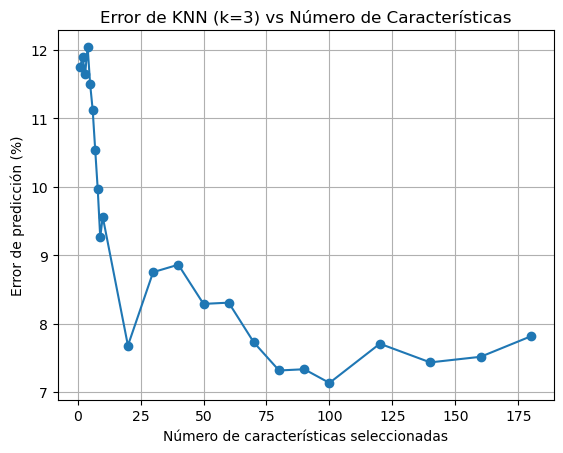

In [ ]:
# Definimos el clasificador KNN con 3 vecinos
knn = KNeighborsClassifier(n_neighbors=3)

# Características que seleccionamos: teniendo en cuenta que no se van a explorar todas
feature_range= np.concatenate([np.arange(1, 10), 
                               np.arange(10, 100, 10),
                               np.arange(100, 200, 20).astype(int)])

out_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
mean_errors = []

for n_features in feature_range:
    print(f"Number of features: {n_features}")
    accuracies = []
    fold = 1
    errors = []
    for train_idx, test_idx in out_cv.split(X, y):
        # Generamos los conjuntos de entrenamiento y prueba
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        # Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # Seleccionamos el número de atributos que queremos utilizando F-score
        feature_selector = SelectKBest(f_classif, k=n_features)
        X_train_selection = feature_selector.fit_transform(X_train_scaled, y_train)
        X_test_selection = feature_selector.transform(X_test_scaled)

        # Entrenamos el clasificador KNN
        knn.fit(X_train_selection, y_train)
        # Hacemos predicciones sobre el conjunto de prueba
        predictions = knn.predict(X_test_selection)
        # Calculamos la precisión del modelo
        error = 1 - accuracy_score(y_test, predictions)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))




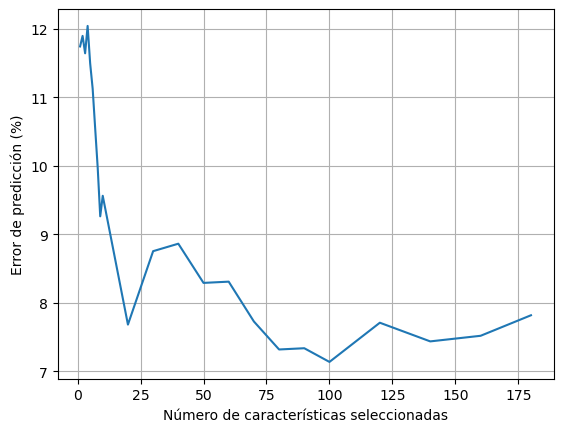

In [11]:
plt.plot(feature_range, np.array(mean_errors)*100)
plt.xlabel('Número de características seleccionadas')
plt.ylabel('Error de predicción (%)')

plt.grid()
plt.show()

2. Repeat that process when the feature selection is done externally to the cross-validation loop using all the available data. Include these results in the previous plot.


3. Are the two estimates obtained similar? What are their differences? If they are different try to explain why this is the case.

4. By taking a look at these results, what is the optimal number of features to use in this dataset in terms of interpretability vs. prediction error?


5. Given the results obtained in this part of the practical, you are asked to indicate which particular features should be used for prediction on this dataset. Include a list with them. Take a look at the documentation of SelectKBest from scikit-learn to understand how to do this. Use all available data to provide such a list of features. 